# Setup & Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../data/raw/customer_support_data.csv")

# Preview
df.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


## Drop missing CSAT ratings

In [2]:
# Remove rows where Customer Satisfaction Rating is missing
df = df.dropna(subset=['Customer Satisfaction Rating'])

# Confirm it's clean
df['Customer Satisfaction Rating'].isna().sum()

np.int64(0)

## Define features and target

In [5]:
# Target
y = df['Customer Satisfaction Rating'].astype(int)

# Feature matrix (adjusted based on available columns)
features = [
    'Customer Age', 'Customer Gender',
    'Ticket Type', 'Ticket Priority',
    'Ticket Channel', 'Time to Resolution'
]

X = df[features].copy()

# Convert Time to Resolution to hours (if not already done)
X['Time to Resolution'] = pd.to_datetime(X['Time to Resolution'], errors='coerce')
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], errors='coerce')
X['Resolution Time (hrs)'] = (X['Time to Resolution'] - df['Date of Purchase']).dt.total_seconds() / 3600

# Drop original datetime column
X.drop(columns='Time to Resolution', inplace=True)

# Preview
X.head()


,Customer Age,Customer Gender,Ticket Type,Ticket Priority,Ticket Channel,Resolution Time (hrs)
2,48,Other,Technical issue,Low,Social media,25266.093889
3,27,Female,Billing inquiry,Low,Social media,22321.961111
4,67,Female,Billing inquiry,Low,Email,29131.895000
10,48,Male,Cancellation request,High,Phone,20711.863611
11,51,Male,Product inquiry,High,Chat,14049.464167


## Encode Categorical Variables

In [10]:
import sklearn
from sklearn.preprocessing import LabelEncoder

categoricals = ['Customer Gender', 'Ticket Type', 'Ticket Priority', 'Ticket Channel']
le_dict = {}

for col in categoricals:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  # Save encoders if needed later


## Train/test split & model training

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.2003610108303249
              precision    recall  f1-score   support

           1       0.22      0.25      0.23       109
           2       0.16      0.14      0.15       117
           3       0.18      0.19      0.18       112
           4       0.18      0.19      0.18       108
           5       0.26      0.25      0.25       108

    accuracy                           0.20       554
   macro avg       0.20      0.20      0.20       554
weighted avg       0.20      0.20      0.20       554



## Feature Importance Plot

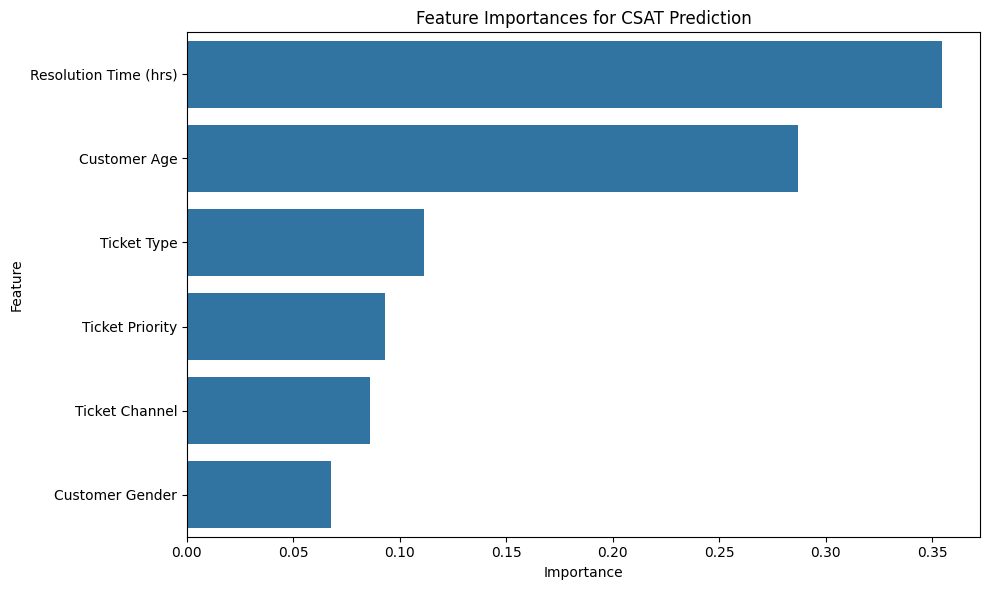

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title("Feature Importances for CSAT Prediction")
plt.tight_layout()
plt.show()


The feature importance chart clearly shows that:
- Resolution Time (hrs) and Customer Age are the strongest predictors of CSAT.
- Categorical variables like Ticket Type, Priority, and Channel have moderate influence.
- Customer Gender contributes the least.

## Confusion Matrix to Visualize Performance

<Figure size 800x600 with 0 Axes>

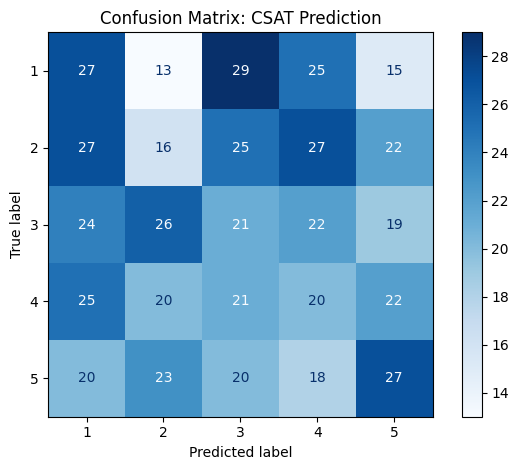

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: CSAT Prediction")
plt.tight_layout()
plt.show()


### 📊 CSAT Prediction Model Summary

- **Model Used:** Random Forest Classifier  
- **Target Variable:** Customer Satisfaction Rating (1 to 5)

#### ⚙️ Features Used:
- Customer Age  
- Customer Gender  
- Ticket Type  
- Ticket Priority  
- Ticket Channel  
- Resolution Time (hrs)

#### 📉 Model Performance:
- **Accuracy:** 20%
- **F1-scores per class:** Between 0.15 and 0.25  
- The model performs poorly in predicting the exact CSAT score due to class overlap and possibly noisy labels.

#### 🔍 Insights:
- **Most important features:**  
  1. Resolution Time (hrs)  
  2. Customer Age  
  3. Ticket Type

#### 📌 Recommendations:
- Consider **reframing** as a binary classification task (e.g., Satisfied [4–5] vs Unsatisfied [1–3])  
- Try **advanced models** (e.g., XGBoost, CatBoost)  
- Apply **class balancing**, **feature engineering**, and possibly **hyperparameter tuning**


# Binary CSAT Classification

We'll create a new target variable called CSAT_Binary:
- 1 (Satisfied): If Customer Satisfaction Rating is 4 or 5
- 0 (Unsatisfied): If the rating is 1, 2, or 3

In [16]:
# Convert CSAT to binary: 1 if rating is 4 or 5, else 0
df['CSAT_Binary'] = df['Customer Satisfaction Rating'].apply(lambda x: 1 if x >= 4 else 0)

# Define new target and use same features
y = df['CSAT_Binary']


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf_bin = RandomForestClassifier(random_state=42)
clf_bin.fit(X_train, y_train)

# Predict
y_pred_bin = clf_bin.predict(X_test)

# Evaluate
print("Binary Classification Accuracy:", accuracy_score(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin))


Binary Classification Accuracy: 0.572202166064982
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       338
           1       0.42      0.25      0.31       216

    accuracy                           0.57       554
   macro avg       0.52      0.51      0.50       554
weighted avg       0.54      0.57      0.54       554



<Figure size 600x400 with 0 Axes>

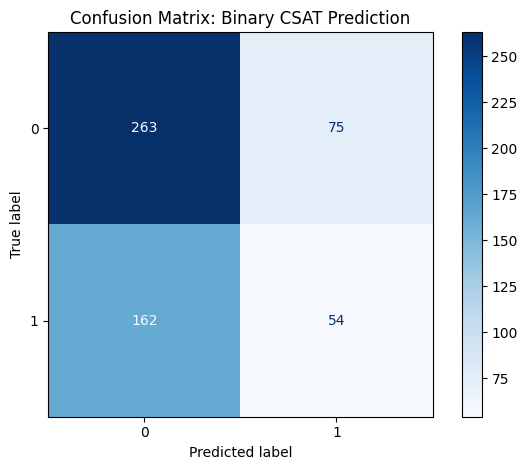

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_bin.classes_)

# Plot
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Binary CSAT Prediction")
plt.tight_layout()
plt.show()


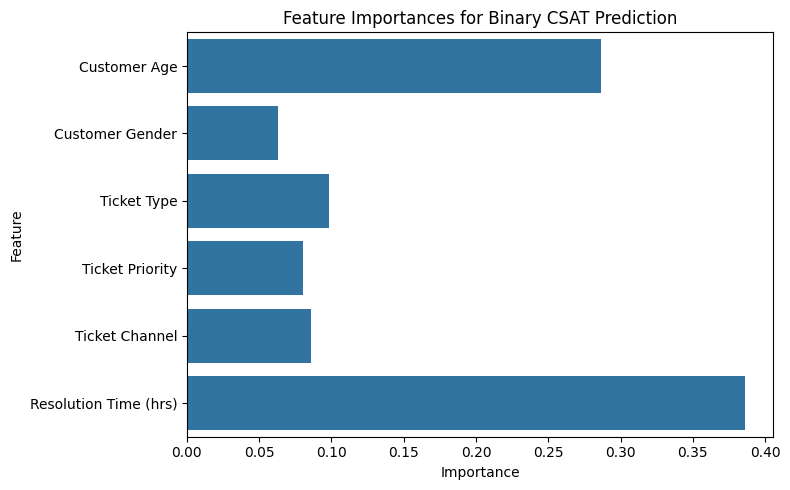

In [19]:
# Feature importances for binary model
importances_bin = clf_bin.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances_bin, y=features)
plt.title("Feature Importances for Binary CSAT Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### 🔍 Feature Importance for Binary CSAT Prediction

The model identified the following features as key drivers for predicting whether a customer is satisfied (1) or dissatisfied (0):

- **Resolution Time (hrs)**: By far the most impactful feature. Longer resolution times strongly correlate with customer dissatisfaction.
- **Customer Age**: Plays a significant role—suggesting that different age groups may have varying expectations or tolerance levels.
- **Ticket Type, Priority, Channel, and Gender**: These features contribute marginally compared to time-based factors, but still offer contextual value in prediction.

📌 **Takeaway:** Speed of issue resolution is the biggest lever for boosting customer satisfaction in this dataset.


## 📈 Model Performance Summary & Next Steps

The Random Forest model for predicting binary CSAT achieved:

- **Accuracy**: ~57%
- **Precision/Recall**: Precision was stronger for satisfied customers (class 0), but recall was lower for dissatisfied customers (class 1), indicating a bias in class prediction.
- **Confusion Matrix**: Shows the model struggled to correctly identify dissatisfied users (many false negatives).

### ✅ Key Insights
- **Resolution Time** and **Customer Age** are the most predictive features.
- Class imbalance may have contributed to reduced performance for dissatisfied predictions.

### 🚀 Next Steps for Improvement
- Perform **feature engineering** on text fields (e.g., Ticket Subject or Description) using NLP techniques.
- Apply **resampling techniques** (e.g., SMOTE) to balance the target class.
- Try other models like **Gradient Boosting**, **XGBoost**, or **Logistic Regression** with hyperparameter tuning.
- Use **cross-validation** to improve generalization.

This forms a strong foundation for demonstrating predictive modeling and customer analytics in a support environment.
